# SpaceRocks

### Vectorized coordinate transformation and ephemeris calculation with robust unit handling.

To install, simply `pip install spacerocks`

In [1]:
from spacerocks import SpaceRock
import numpy as np

All of the methods have docstrings in here.

In [2]:
# help(SpaceRock)

Define the distribution of objects. For Keplerian coordinates, you can use either epoch or mean anomaly.

In [3]:
N = int(1e1)
a = np.random.uniform(30, 31, N)
e = np.random.uniform(0, 0.5, N)
inc = np.random.rayleigh(np.pi/15, N)
arg = np.random.uniform(0, 2*np.pi, N)
node = np.random.uniform(0, 2*np.pi, N)
obs_date = 2480000
H = np.random.uniform(4, 7, N)

# It doesn't matter which one you use.
epoch = np.random.uniform(2400000, 2480000, N)
M = np.random.uniform(0, 2*np.pi, N)

Call the class SpaceRock. The default settings are as described in the help page. All arguments and keyword arguments are case-insensitive.

- input_coordinates can be Keplerian or Cartesian
- input_frame can be Barycentric or Heliocentric 
- input_angles can be radians or degrees
- NSIDE is a list (or an array) of the NSIDE healpix values you want calculated.

It's vectorized, so you can pass in as many objects as you want. Note that tau is the observation date.

In [4]:
rocks = SpaceRock(a=a, 
                  e=e, 
                  inc=inc, 
                  arg=arg, 
                  node=node, 
                  epoch=epoch, 
                  tau=obs_date,
                  H=H,
                  name=['rock{}'.format(idx) for idx in range(N)], # default is a random 10-digit integer.
                  NSIDE=[128, 256, 1024],
                  precise=False,
                  input_coordinates='keplerian',
                  input_frame='barycentric',
                  input_angles='radians')

You can get a look at the data by writing it to either a pandas dataframe of an astropy table. In my opinion pandas dataframes are nicer to work with, but they don't support astropy units (yet).

In [5]:
rocks_df = rocks.pandas_df()
rocks_df.head()

,name,a,e,inc,arg,node,varpi,epoch,M,tau,...,delta,ltt,phase_angle,elong,r,HPIX_128,HPIX_256,HPIX_1024,H,mag
0,rock0,30.003781,0.004151,0.160746,1.063272,1.339718,2.402990,2.439768e+06,4.213970,2480000.0,...,29.081673,0.167962,0.006867,2.934254,30.063720,72025,288101,4609630,6.497433,21.205744
1,rock1,30.451490,0.488082,0.122547,2.440360,0.713319,3.153679,2.470082e+06,1.015985,2480000.0,...,29.158367,0.168405,0.032803,1.843017,29.443775,191950,767802,12284837,6.209626,20.878409
2,rock2,30.807934,0.165835,0.448957,2.708327,5.618621,2.043762,2.432018e+06,4.830251,2480000.0,...,30.868832,0.178284,0.032393,1.735200,31.051970,80979,323916,5182663,4.373358,19.281405
3,rock3,30.301220,0.074873,0.226737,5.413129,4.357715,3.487659,2.454854e+06,2.595178,2480000.0,...,32.898388,0.190005,0.023725,0.885446,32.281402,75759,303037,4848602,6.667463,21.798098
4,rock4,30.637365,0.234187,0.160006,5.505221,3.382755,2.604791,2.405179e+06,7.594980,2480000.0,...,31.076008,0.179480,0.024814,0.878566,30.458817,122963,491853,7869653,6.565088,21.445779


In [6]:
rocks_table = rocks.astropy_table()
rocks_table[:5]

name,a,e,inc,arg,node,varpi,epoch,M,tau,x,y,z,vx,vy,vz,ra,dec,delta,ltt,phase_angle,elong,r,HPIX_128,HPIX_256,HPIX_1024,H,mag
,AU,,rad,rad,rad,rad,d,rad,d,AU,AU,AU,AU / yr,AU / yr,AU / yr,rad,rad,AU,d,rad,rad,AU,,,,,
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64
rock0,30.003781488454,0.004151211307708069,0.16074627291687538,1.0632718790655151,1.3397178840208244,2.4029897630863397,2439767.725062848,4.213969857155366,2480000.0,28.15534009313804,9.717657537323753,-4.083038214528049,-0.0009957790783426085,0.002962054963829696,0.00026716724786821327,0.36463819882569837,0.00158332269198039,29.081673157838893,0.16796173643195772,0.006866662138936041,2.934254167629788,30.063719743808615,72025,288101,4609630,6.497433180580906,21.205743697828858
rock1,30.451490048672788,0.48808170495728403,0.12254738598547628,2.4403601650466817,0.7133185757312875,3.1536787407779694,2470082.1133981193,1.0159846373032433,2480000.0,12.977772301538984,-26.198502433984746,-3.485942455568223,0.003209944257809524,-0.00013939636216355218,-0.0002716797998670164,5.196596608166715,-0.4883446406872402,29.15836725991926,0.168404684624436,0.032803128448009436,1.8430165068617446,29.44377520797274,191950,767802,12284837,6.209625624126522,20.878409099869216
rock2,30.80793384286378,0.16583533310882237,0.4489566329452003,2.7083266770719367,5.618620671384917,2.043762041277269,2432017.5126835494,4.830251263745086,2480000.0,28.49845098770502,6.0325111721135025,10.755089906624326,-0.0013579205822159088,0.0026911571354740313,0.0006171399133651835,0.07502728295736727,0.42180462200886826,30.868832016938608,0.17828350518387817,0.032393429919631365,1.7352003836112675,31.05197028595564,80979,323916,5182663,4.373357976014011,19.28140477259008
rock3,30.30122042872275,0.07487321367171462,0.22673710111401257,5.41312914383541,4.35771525822775,3.4876590948835737,2454853.559566591,2.5951780654645122,2480000.0,31.260710571117258,-3.8530935299871345,7.0718123192764635,0.0004943704173044387,0.0028843742535763803,-0.00012414134962779907,6.062883747795926,0.1409581475472193,32.89838759849532,0.1900052406498292,0.023724564170111123,0.885446474371973,32.281401528450736,75759,303037,4848602,6.667463134020444,21.798098107998214
rock4,30.637364997707884,0.23418658992475905,0.1600063781359718,5.505220555828727,3.382755292738481,2.6047905413876222,2405179.1028293995,7.5949797588934915,2480000.0,-9.795166677365097,-28.548439617124405,4.096441269755387,0.0026418122047369,-0.0016363761015461753,0.0003582720339283344,4.398797706507537,-0.2579467124042549,31.076008431416497,0.1794800563635366,0.02481400940008601,0.8785659920087773,30.458816882579615,122963,491853,7869653,6.565087520820574,21.445778823592626


You can also pass in just a single object. I'll try BP519. Here I've turned on precision. This involves a non-vectorized solution to Kepler's equation to calculate the eccentric anomaly, and a topocentric correction to the Earth's position. Right now, only DECam is supported, but I'm working on implementing an obscode feature.

In [7]:
BP = SpaceRock(a=4.490784528803734E+02, 
               e=9.215119038599956E-01, 
               inc=5.411067896592579E+01, 
               arg=3.480604843629308E+02, 
               node=1.352131890380128E+02, 
               epoch=2458285.5, 
               tau=2458385.5,
               H=4.4, 
               name='BP',
               precise=True,
               input_coordinates='keplerian',
               input_frame='barycentric',
               input_angles='degrees')

In [8]:
BP.predict(np.array([2458285.5, 2458286.5, 2458287.5, 2458288.5]))

,name,tau,ra,dec,M,delta,r,ltt,phase_angle,elong,mag
0,BP,2458285.5,2.225560,0.170399,0.000181,35.972456,35.248412,0.207760,0.019733,0.760581,19.915548
1,BP,2458286.5,2.225648,0.170469,0.000183,35.972442,35.248434,0.207759,0.019734,0.760632,19.915549
2,BP,2458287.5,2.225736,0.170540,0.000185,35.972428,35.248456,0.207759,0.019735,0.760683,19.915549
3,BP,2458288.5,2.225824,0.170611,0.000186,35.972414,35.248479,0.207759,0.019736,0.760734,19.915550


Printing out the results:

In [9]:
BP.pandas_df()

,name,a,e,inc,arg,node,varpi,epoch,M,tau,...,vz,ra,dec,delta,ltt,phase_angle,elong,r,H,mag
0,BP,449.078453,0.921512,0.94441,6.074801,2.359915,2.151531,2458285.5,0.000186,2458288.5,...,0.00319,2.225824,0.170611,35.972414,0.207759,0.019736,0.760734,35.248479,4.4,19.91555


You can also go between heliocentric and barycentric coordinates with the to_helio() and to_bary() methods.

In [10]:
BP_helio = BP.to_helio()
BP_helio.pandas_df()

,name,a,e,inc,arg,node,varpi,epoch,M,tau,...,vz,ra,dec,delta,ltt,phase_angle,elong,r,H,mag
0,BP,17.621933,0.94529,0.94441,1.307606,2.315553,2.151531,2458285.5,6.262102,2458288.5,...,0.003127,2.225824,0.170611,35.972414,0.207759,0.019736,0.760734,35.243615,4.4,19.91555


In [11]:
BP_bary = BP_helio.to_bary()
# Check that bary -> helio -> bary worked.
BP_bary == BP

True

You can predict the position of a lot of objects at a given date

In [12]:
rocks = SpaceRock(a=a, 
                  e=e, 
                  inc=inc, 
                  arg=arg, 
                  node=node, 
                  epoch=epoch, 
                  tau=obs_date,
                  H=H,
                  name=['rock{}'.format(idx) for idx in range(N)], # default is a random 10-digit integer.
                  NSIDE=[128, 256, 1024],
                  precise=False,
                  input_coordinates='keplerian',
                  input_frame='barycentric',
                  input_angles='radians')

rocks_tomorrow = rocks.predict(2458385.5)
rocks_tomorrow

,name,tau,ra,dec,M,delta,r,ltt,phase_angle,elong,HPIX_128,HPIX_256,HPIX_1024,mag
0,rock0,2458385.5,2.387463,0.422046,6.164015,30.387613,29.880120,0.175504,0.028705,1.025885,19553,78215,1251452,21.287828
1,rock1,2458385.5,2.688149,0.308054,-0.182212,17.245422,16.485764,0.099601,0.038808,0.691841,17736,70944,1135105,18.478540
2,rock2,2458385.5,3.299325,-0.500545,7.484636,29.803666,29.757639,0.172132,0.034199,1.508539,98678,394713,6315412,19.112699
3,rock3,2458385.5,0.080753,0.243791,2.959684,32.890792,32.537536,0.189961,0.028243,1.191515,78673,314695,5035124,21.814758
4,rock4,2458385.5,3.312932,-0.089102,12.995897,24.154802,24.529695,0.139506,0.037275,1.943924,104595,418380,6694095,20.428566
5,rock5,2458385.5,4.712332,-0.482708,7.220120,27.196395,28.167791,0.157073,0.010148,2.855017,115471,461884,7390159,19.414746
6,rock6,2458385.5,0.314023,0.245041,5.189128,30.308330,29.323384,0.175046,0.004745,0.140283,73634,294539,4712631,20.677490
7,rock7,2458385.5,3.310606,0.002852,9.873664,37.550959,38.543537,0.216876,0.003209,3.017609,105052,420210,6723360,20.106267
8,rock8,2458385.5,2.643351,-0.109728,-1.173147,30.519037,30.742200,0.176263,0.032107,1.777864,107256,429025,6864405,19.619087
9,rock9,2458385.5,6.131823,0.218468,8.961561,34.014592,34.560558,0.196452,0.023991,2.144739,79938,319752,5116039,20.371016


Or if you want, you can predice the position of a lot of objects at a lot of different dates.

In [13]:
rocks = SpaceRock(a=a, 
                  e=e, 
                  inc=inc, 
                  arg=arg, 
                  node=node, 
                  epoch=epoch, 
                  tau=obs_date,
                  H=H,
                  name=['rock{}'.format(idx) for idx in range(N)], # default is a random 10-digit integer.
                  NSIDE=[128, 256, 1024],
                  precise=False,
                  input_coordinates='keplerian',
                  input_frame='barycentric',
                  input_angles='radians')


rocks_on_many_days = rocks.predict(np.random.uniform(2458385.5, 2868985.5, N))
rocks_on_many_days

,name,tau,ra,dec,M,delta,r,ltt,phase_angle,elong,HPIX_128,HPIX_256,HPIX_1024,mag
0,rock0,2.815401e+06,2.054340,0.462624,43.558179,30.117962,29.890353,0.173947,0.032552,1.325586,24846,99384,1590155,21.269216
1,rock1,2.815401e+06,0.865694,0.342226,36.390317,32.887538,33.620363,0.189943,0.020577,2.380133,1686,6747,107958,21.427794
2,rock2,2.815401e+06,1.259511,0.799713,43.424296,27.505860,26.770666,0.158861,0.026027,0.752386,7234,28937,463003,18.708780
3,rock3,2.815401e+06,5.663405,-0.018760,39.804605,32.452537,31.575944,0.187430,0.014315,0.474575,76357,305431,4886899,21.720488
4,rock4,2.815401e+06,1.072350,0.236331,49.236107,27.891965,28.386842,0.161091,0.030132,2.084013,93947,375789,6012628,21.058068
5,rock5,2.815401e+06,0.875701,0.344837,42.901558,31.139861,30.199498,0.179849,0.012123,0.370472,1687,6749,107988,19.860007
6,rock6,2.815401e+06,5.943964,-0.004545,41.913661,39.472579,38.663739,0.227975,0.014836,0.614367,75407,301629,4826071,21.851606
7,rock7,2.815401e+06,2.313006,0.618860,45.859740,34.501201,35.021510,0.199262,0.024570,2.105643,20378,81512,1304195,19.714250
8,rock8,2.815401e+06,1.589787,0.488213,34.553316,43.530735,42.738318,0.251413,0.014459,0.659591,97502,390009,6240154,21.105625
9,rock9,2.815401e+06,5.822911,0.131516,46.253340,33.340583,33.605754,0.192559,0.028411,1.828499,77341,309364,4949824,20.266720


You can calculate the predicted position of the same object at many dates. This could probably be cleaner, but it may take some doing to implement.

In [14]:
N = 3
BP = SpaceRock(a=np.repeat(4.490784528803734E+02, N), 
               e=np.repeat(9.215119038599956E-01, N), 
               inc=np.repeat(5.411067896592579E+01, N), 
               arg=np.repeat(3.480604843629308E+02, N), 
               node=np.repeat(1.352131890380128E+02, N), 
               epoch=np.repeat(2458285.5, N), 
               tau=np.linspace(2058285.5, 2458285.5, N),
               H=np.repeat(4.4, N), 
               name=['rock{}'.format(idx) for idx in range(N)],
               precise=False,
               input_coordinates='keplerian',
               input_frame='barycentric',
               input_angles='degrees')

You quickly plot the equatorial position. 

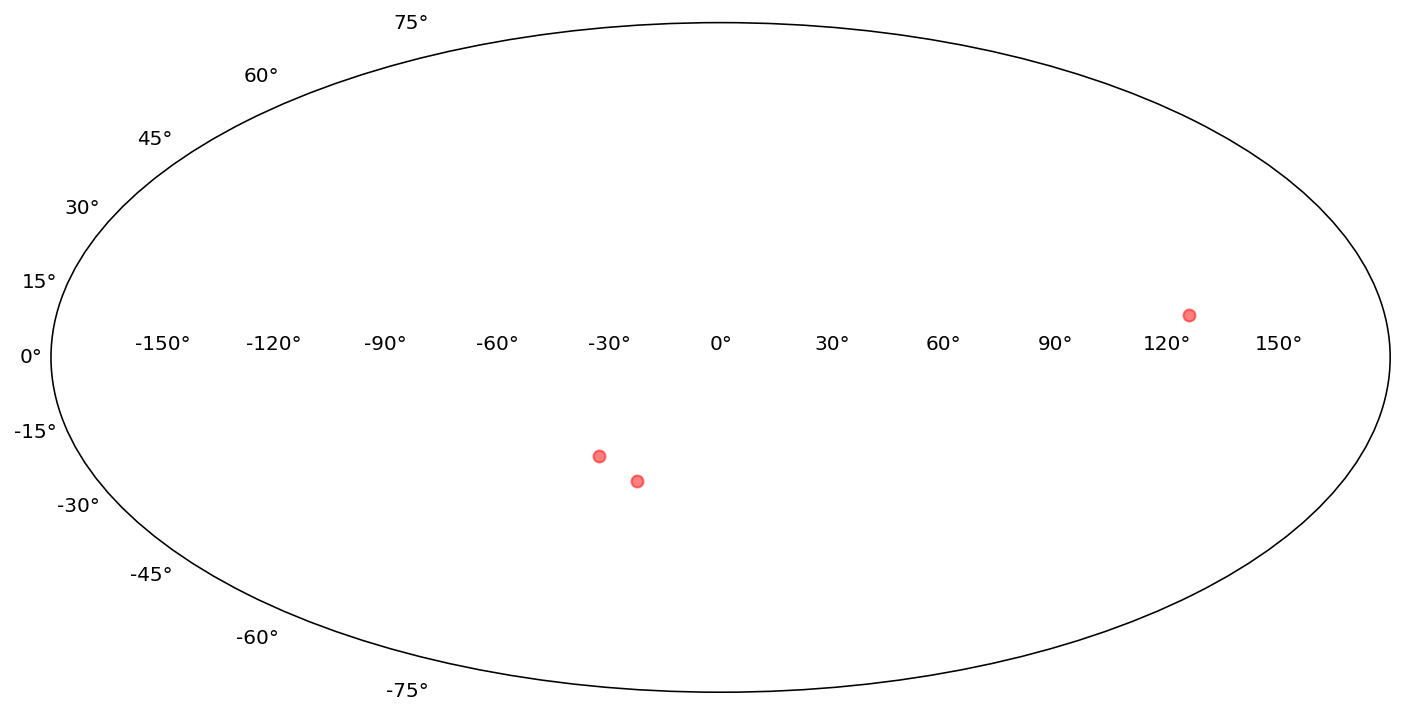

In [29]:
BP.plot_radec('red')

If you want to keep your calculations, you can write them to a file like this.

In [ ]:
path = '/wherever/you/want/the/file.csv'
BP.write_to_csv(path)